In [116]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py
import random

import gym
import numpy as np
import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv, VecFrameStack
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

import interp

In [4]:
########### Set Device ############
# device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device = 'cpu'
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cpu


In [5]:
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = ALGOS['a2c']('CnnPolicy', env).policy
        self.reward_net = nn.Linear(512, 1).to(device)
        self.device = device
    
    def forward(self, obs):
        obs_transposed = VecTransposeImage.transpose_image(obs)
        latent, _, _= self.ac_model._get_latent(th.tensor(obs_transposed).to(self.device))
        return self.reward_net(latent)
    
    def forward_tensor(self, obs):
        """obs is a tensor which has already been transposed correctly."""
        latent, _, _= self.ac_model._get_latent(obs.to(self.device))
        return self.reward_net(latent)
    
    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False

In [6]:
def get_mask(center, size, r):
    y,x = np.ogrid[-center[0]:size[0]-center[0], -center[1]:size[1]-center[1]]
    keep = x*x + y*y <= 1
    mask = np.zeros(size) ; mask[keep] = 1 # select a circle of pixels
    mask = scipy.ndimage.gaussian_filter(mask, sigma=r) # blur the circle of pixels. this is a 2D Gaussian for r=r^2=1
    return mask/mask.max()

def occlude(img, mask):
    assert img.shape[1:] == (84, 84, 4)
    img = np.copy(img)
    for k in range(4):
        I = img[0, :, :, k]
        img[0, :, :, k] = I*(1-mask) + scipy.ndimage.gaussian_filter(I, sigma=3)*mask
    return img

def compute_saliency_map(reward_model, obs, stride=5, radius=5):
    baseline = reward_model(obs).detach().cpu().numpy()
    scores = np.zeros((84 // stride + 1, 84 // stride + 1))
    for i in range(0, 84, stride):
        for j in range(0, 84, stride):
            mask = get_mask(center=(i, j), size=(84, 84), r=radius)
            obs_perturbed = occlude(obs, mask)
            perturbed_reward = reward_model(obs_perturbed).detach().cpu().numpy()
            scores[i // stride, j // stride] = 0.5 * np.abs(perturbed_reward - baseline) ** 2
    pmax = scores.max()
    scores = skimage.transform.resize(scores, output_shape=(210, 160))
    scores = scores.astype(np.float32)
#     return pmax * scores / scores.max()
    return scores / scores.max()

def add_saliency_to_frame(frame, saliency, channel=1):
#     def saliency_on_atari_frame(saliency, atari, fudge_factor, channel=2, sigma=0):
    # sometimes saliency maps are a bit clearer if you blur them
    # slightly...sigma adjusts the radius of that blur
    pmax = saliency.max()
    I = frame.astype('uint16')
    I[:, :, channel] += (frame.max() * saliency).astype('uint16')
    I = I.clip(1,255).astype('uint8')
    return I

In [5]:
env_id = "BreakoutNoFrameskip-v4"
folder = "/home/eric/interpreting-rewards/scripts/output/regressed_exps/"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [6]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

Stacking 4 frames


In [7]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/BreakoutNoFrameskip-v4-reward_model.pt"))
rm = rm.to(device)

In [8]:
random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.backends.cudnn.deterministic = True
th.backends.cudnn.benchmark = False

breakout_images = []
n = 0

obs = env.reset()
while n < 5:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        obs = env.reset()
    use = (reward[0] and not random.randint(0, 9)) or \
            (not reward[0] and not random.randint(0, 50))
    if use:
        n += 1
        sal = compute_saliency_map(rm, obs)
        screenshot = env.render(mode='rgb_array')
        image = add_saliency_to_frame(screenshot, sal)
        breakout_images.append(image)
            

In [9]:
env_id = "SeaquestNoFrameskip-v4"
folder = "/home/eric/interpreting-rewards/scripts/output/regressed_exps/"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [10]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

Stacking 4 frames


In [11]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/SeaquestNoFrameskip-v4-reward_model.pt"))
rm = rm.to(device)

In [12]:
random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.backends.cudnn.deterministic = True
th.backends.cudnn.benchmark = False

seaquest_images = []
n = 0

obs = env.reset()
cumulative_reward = 0
while n < 5:
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    cumulative_reward += reward
    if done:
        obs = env.reset()
    use = (reward[0] and not random.randint(0, 9)) or \
            (not reward[0] and not random.randint(0, 50)) and cumulative_reward >= 1
    if use:
        n += 1
        sal = compute_saliency_map(rm, obs)
        screenshot = env.render(mode='rgb_array')
        image = add_saliency_to_frame(screenshot, sal)
        seaquest_images.append(image)
            

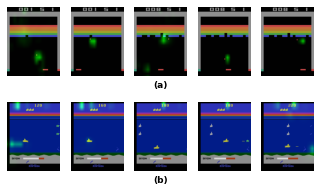

In [15]:
plt.figure(figsize=(5.5, 3.2))

for k in range(5):
    ax = plt.subplot(2, 5, k+1)
    ax.imshow(breakout_images[k])
    ax.axis('off')
    if k == 2:
        ax.text(0.5, -0.17, "(a)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)
        
for k in range(5):
    ax = plt.subplot(2, 5, 5 + k+1)
    ax.imshow(seaquest_images[k])
    ax.axis('off')
    if k == 2:
        ax.text(0.5, -0.17, "(b)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)

plt.savefig('figures/atarisaliencymaps.pdf', dpi=300)

# timeseries plots

In [117]:
env_id = "BreakoutNoFrameskipNoScore-v4"
folder = "/home/eric/interpreting-rewards/scripts/output/regressed_exps/"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [11]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

Stacking 4 frames


In [12]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/BreakoutNoFrameskip-v4-reward_model.pt"))
rm = rm.to(device)


In [20]:
radius = 5
stride = 4

TIMESTEPS = 200

breakout_obs = env.reset()
breakout_rewards = []
for i in tqdm(range(TIMESTEPS)):
    action, _states = model.predict(breakout_obs, deterministic=False)
    breakout_obs, reward, done, info = env.step(action)
    if done:
        breakout_obs = env.reset()
    if i == TIMESTEPS - 1:
        sal = compute_saliency_map(rm, breakout_obs)
        screenshot = env.render(mode='rgb_array')
        breakout_image = add_saliency_to_frame(screenshot, sal)
    breakout_rewards.append(rm(breakout_obs).item())

In [21]:
env_id = "SeaquestNoFrameskipNoScore-v4"
folder = "/home/eric/interpreting-rewards/scripts/output/regressed_exps/"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [22]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

Stacking 4 frames


In [23]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load(f"../reward-models/SeaquestNoFrameskip-v4-reward_model.pt"))
rm = rm.to(device)

In [24]:
radius = 5
stride = 4

TIMESTEPS = 200

seaquest_obs = env.reset()
seaquest_rewards = []
for i in tqdm(range(TIMESTEPS)):
    action, _states = model.predict(seaquest_obs, deterministic=False)
    seaquest_obs, reward, done, info = env.step(action)
    if done:
        seaquest_obs = env.reset()
    if i == TIMESTEPS - 1:
        sal = compute_saliency_map(rm, seaquest_obs)
        screenshot = env.render(mode='rgb_array')
        seaquest_image = add_saliency_to_frame(screenshot, sal)
    seaquest_rewards.append(rm(seaquest_obs).item())

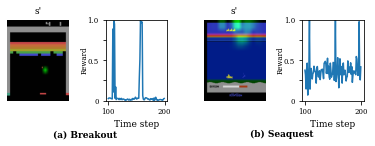

In [136]:
fig, (ax2, ax1, ax4, ax3) = plt.subplots(1, 4, figsize=(5.5, 2), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

ax1.plot(list(range(100, 200)), breakout_rewards[100:])
ax1.set_ylim(0, 1)
ax1.set_xlabel('Time step', fontsize=9, fontfamily='Serif')
ax1.set_ylabel('Reward', fontsize=7, fontfamily='Serif')
ax1.set_xticklabels([None, 100, 200], fontsize=7, fontfamily='Serif')
ax1.set_yticklabels([0, None, 0.5, None, 1.0], fontsize=7, fontfamily='Serif')

ax2.imshow(breakout_image)
ax2.axis('off')
ax2.set_title("s'", fontsize=9, fontfamily='Serif')

asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
asp /= np.abs(np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0])
ax1.set_aspect(asp)
ax1.text(-0.33, -0.45, "(a) Breakout", size=9, ha="center", weight="bold", fontfamily='Serif', 
         transform=ax1.transAxes)
ax1.yaxis.labelpad=-1

ax3.plot(list(range(100, 200)), seaquest_rewards[100:])
ax3.set_ylim(0, 1)
ax3.set_xlabel('Time step', fontsize=9, fontfamily='Serif')
ax3.set_ylabel('Reward', fontsize=7, fontfamily='Serif')
ax3.set_xticklabels([None, 100, 200], fontsize=7, fontfamily='Serif')
ax3.set_yticklabels([0, None, 0.5, None, 1.0], fontsize=7, fontfamily='Serif')

ax4.imshow(seaquest_image)
ax4.axis('off')
ax4.set_title("s'", fontsize=9, fontfamily='Serif')

asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
asp /= np.abs(np.diff(ax4.get_xlim())[0] / np.diff(ax4.get_ylim())[0])
ax3.set_aspect(asp)
ax3.text(-0.33, -0.45, "(b) Seaquest", size=9, ha="center", weight="bold", fontfamily='Serif', 
         transform=ax3.transAxes)
ax3.yaxis.labelpad=-1

plt.subplots_adjust(wspace=0.6, top=0.99, bottom=0.17, left=0.05, right=0.95)

plt.savefig('figures/atari-noscore-timeseries.pdf', dpi=300)